In [18]:

#importing libraries for model evaluation and algorithms
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [19]:
#reading the dataframe
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [20]:
#removing the neutral sentiments considering that positive and negative sentiments matter more 
df=df[df['airline_sentiment']!='neutral']
#now since neutral elements are deleted so I need to reset the indices
df.reset_index(inplace=True,drop=True)
#positive sentiments to 1 and negative to 0 
def partition(x):
    if x =='positive':
        return 1
    return 0
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    2363
Name: Sentiment, dtype: int64

In [ ]:
df.head()

In [22]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 512  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [24]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [25]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [26]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [27]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
docs=[ clean(doc) for doc in docs]      

In [ ]:
#docs was the cleaned lemmatized text which has been appended into the dataframe for further use
df['CleanedText']=docs
df['CleanedText']=df['CleanedText'].str.decode("utf-8")
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
df.text = df.CleanedText.apply(remove_mentions)
df.head()

In [29]:
#taking only two columns in the dataframe 
df=df[['CleanedText','Sentiment']]
df.head()

,CleanedText,Sentiment
0,virginamerica plus 've added commercial experi...,1
1,virginamerica 's really aggressive blast obnox...,0
2,virginamerica 's really big bad thing,0
3,virginamerica seriously would pay 30 flight se...,0
4,virginamerica yes nearly every time fly vx “ e...,1


In [30]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'], df.Sentiment, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 9232
# Test data samples: 2309


In [31]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 9232 documents
15000 words in dictionary
Top 5 most common words are: [('united', 2739), ('flight', 2673), ('usairways', 2138), ('americanair', 1957), ("n't", 1458)]


In [32]:
#transform each text in X_train and X_test to a sequence of vectors
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)


In [33]:
#an example of the output generated is as follows
print(X_train[1],"\n")
print(X_train_seq[0])

virginamerica 's really aggressive blast obnoxious `` entertainment '' guest face amp little recourse 

[3, 90, 1405, 412, 328, 144, 1678, 27, 588, 96, 163, 148, 4607, 3251, 4608, 2570, 3252, 271, 89]


In [34]:
#so that all training features have the same length, we one hot encode them such that each has a length of num_words with 1s in places
#where the vector occured. 
def one_hot_seq(seqs, nb_features = num_words):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[1], X_train_oh[1]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[1].sum()))

"[3, 4609, 25, 1200, 280, 789, 1054, 573, 204, 1055, 25, 372, 55, 34, 126, 494]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 15.0 features with a value of 1.


In [35]:
#one hot encoding for the target variables
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
print('"{}" is converted into {}'.format(y_train[1], y_train_oh[1]))

"0" is converted into [1. 0.]


In [ ]:
#getting validation data as a part of training data
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)
print('Shape of validation set:',X_valid.shape)

**I will be displaying three variants of the model, first is the basic model using Dense Layers, second involves regularization and third involves addition of dropout layer. I am going to examine the effects of each of these strategies**

In [37]:
#starting with a base model
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(num_words,)))
base_model.add(layers.Dense(32, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960064    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 962,210
Trainable params: 962,210
Non-trainable params: 0
_________________________________________________________________


In [38]:
#A function to fit the models on training set by optimizing using adam's optimzation
def DL_model(model):
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [39]:
#fit the model and plot losses and accuracies for training and validation set
base_history = DL_model(base_model)
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, epochs + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

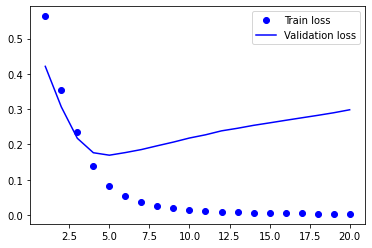

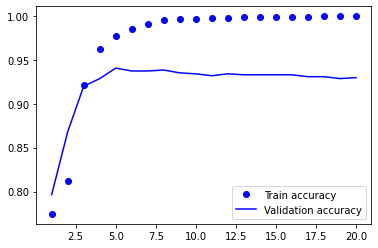

In [40]:
#display the plotted graphs 
eval_metric(base_history, 'loss')
eval_metric(base_history, 'accuracy')

*The graph shows the minima of loss at 2.5 for validation set so optimal no of iterations by baseline model is just 2.*

In [41]:
# A function defined to compare the plots of baseline model and the variations that are going to brought later
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, epochs + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

In [42]:
#The same baseline model after bringing in l2 regularization in two dense layers  
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(num_words,)))
reg_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                960064    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 962,210
Trainable params: 962,210
Non-trainable params: 0
_________________________________________________________________


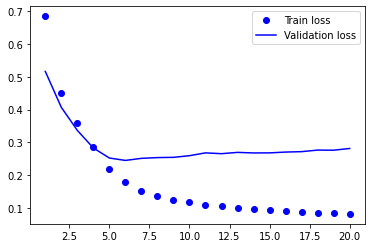

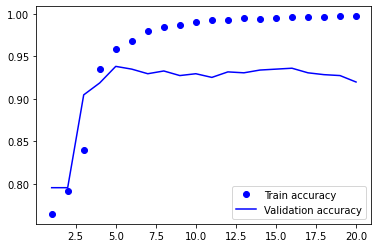

In [43]:
#fit the model and plot losses and accuracies for training and validation set
reg_history = DL_model(reg_model)
eval_metric(reg_history, 'loss')
eval_metric(reg_history, 'accuracy')

*The graph shows the minima of loss at 5 for validation set so optimal no of iterations by baseline model is 5*

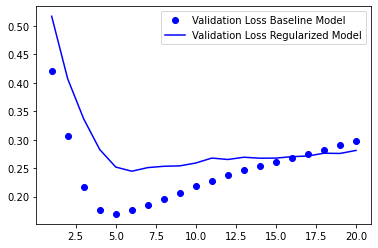

In [44]:
#to compare validation losses of baseline and regularized models with subject to epochs
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [46]:
#The same baseline model after adding two dropout layers after the dense layers  
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(num_words,)))
drop_model.add(layers.Dropout(0.7))
drop_model.add(layers.Dense(32, activation='relu'))
drop_model.add(layers.Dropout(0.3))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                960064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 962,210
Trainable params: 962,210
Non-trainable params: 0
_________________________________________________________________


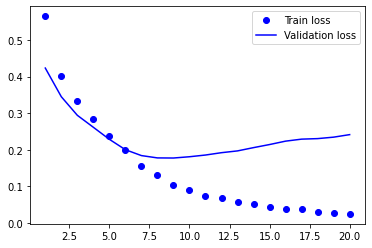

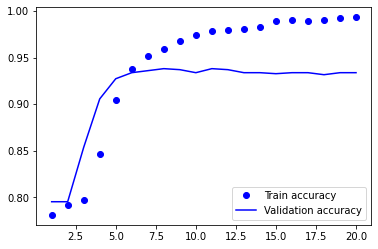

In [47]:
#fit the model and plot losses and accuracies for training and validation set
drop_history = DL_model(drop_model)
eval_metric(drop_history, 'loss')
eval_metric(drop_history, 'accuracy')

*The graph shows the minima of loss at 7 for validation set so optimal no of iterations by baseline model is 7*

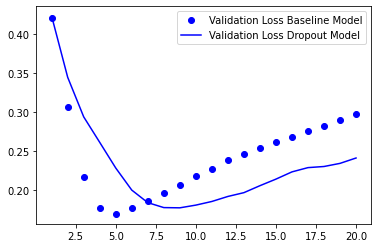

In [48]:
#to compare validation losses of baseline and regularized models with subject to epochs
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [49]:
#Function defined to test the models in the test set
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=batch_size
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [50]:
#base model had two optimal epochs so setting the parameters and evluating. 
base_results = test_model(base_model, 2)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

73/73 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.9186
/n
Test accuracy of baseline model: 91.86%


In [51]:
#regularized base model had five optimal epochs so setting the parameters and evluating. 
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(reg_results[1]*100))

73/73 [==============================] - 0s 4ms/step - loss: 0.3430 - accuracy: 0.9138
/n
Test accuracy of baseline model: 91.38%


In [52]:
#base model after dropout layers had seven optimal epochs so setting the parameters and evluating. 
drop_results = test_model(drop_model, 7)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(drop_results[1]*100))

73/73 [==============================] - 0s 3ms/step - loss: 0.3566 - accuracy: 0.9212
/n
Test accuracy of baseline model: 92.12%


##Now we will see the predictions by our model on sample movie reviews

***Class 1 is positive class and class 0 is negative class***

In [53]:
#First the sample text is a positive review, so lets see its prediction by our model
sample_text = ('The movie was good. Everything was so awesome. Highly recommended.')
#converting into sequence because my model is trained on such a sequence
sample = tk.texts_to_sequences([sample_text])
print(np.array(sample))
samp1=one_hot_seq([sample])
print('For this example we have {} features with a value of 1.'.format(samp1.sum()))

[[2047 1345   94  458 1839  191 1993 4416]]
For this example we have 8.0 features with a value of 1.


In [54]:
#with 99% probability base model has predicted positive class for the tweet
predictions = base_model.predict_classes(np.array(samp1))
prediction_probability=base_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [1]
probabilities of the predicted class for the tweet is [0.00928386 0.9907162 ]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [55]:
#with 97% probability regularized model has also predicted positive class for the tweet
predictions = reg_model.predict_classes(np.array(samp1))
prediction_probability=reg_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [1]
probabilities of the predicted class for the tweet is [0.02513852 0.9748615 ]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [56]:
# The dropout model has also predicted positive class for the tweet with 99.5% probability
predictions = drop_model.predict_classes(np.array(samp1))
prediction_probability=drop_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [1]
probabilities of the predicted class for the tweet is [0.00474656 0.99525344]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [57]:
#Now the sample text is a negative review, so lets see its prediction by our model
sample_text = ('The movie was pathetic and terrible.Nothing was making any sense. Highly unacceptable.')
#converting into sequence because my model is trained on such a sequence
sample = tk.texts_to_sequences([sample_text])
print(np.array(sample))
samp1=one_hot_seq([sample])
print('For this example we have {} features with a value of 1.'.format(samp1.sum()))

[[2047 1345  813 1730  225  171  209 7090  631 1993  255]]
For this example we have 11.0 features with a value of 1.


In [58]:
#The base model has predicted negative class for the tweet with 99.99% probability
predictions = base_model.predict_classes(np.array(samp1))
prediction_probability=base_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [0]
probabilities of the predicted class for the tweet is [9.9999893e-01 1.0541532e-06]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [59]:
#regularized model has also predicted negative class for the tweet with 99.99% probability
predictions = reg_model.predict_classes(np.array(samp1))
prediction_probability=reg_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [0]
probabilities of the predicted class for the tweet is [9.9973089e-01 2.6915973e-04]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [60]:
# The dropout model has predicted negative class for the tweet with 100% probability.
predictions = drop_model.predict_classes(np.array(samp1))
prediction_probability=drop_model.predict(np.array(samp1))
print('class predicted for the tweet is',predictions)
print('probabilities of the predicted class for the tweet is',prediction_probability[0])

class predicted for the tweet is [0]
probabilities of the predicted class for the tweet is [1.0000000e+00 2.3343482e-11]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
